# INSTALLING LIBRARIES

In [1]:
!pip install -r /kaggle/input/bd-requirements/bd_requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 2.8 MB/s eta 0:00:00
  Installing build dependencies ... - \ | / - done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 65.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 84.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 46.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 83.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.5/60.5 MB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
!pip install monai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 4.9 MB/s eta 0:00:00


In [3]:
!pip install tifffile

# IMPORTING MODULES

In [4]:
import os
import glob
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import random
import math
import cv2
from tqdm.notebook import tqdm
from skimage import io, transform
import rasterio as rio
from rasterio import features
from pathlib import Path
import pathlib
import geopandas as gpd
from PIL import Image
import tifffile as tiff
import xarray as xr
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from collections import defaultdict
import torch
import torch.optim as optim
from torch import nn
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, Sampler, BatchSampler
from sklearn.model_selection import train_test_split
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.encoders import get_preprocessing_fn
from monai.networks.nets import UNet

2024-06-18 10:34:25.472684: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-18 10:34:25.472784: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-18 10:34:25.597042: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# GETTING FILE PATHS

In [5]:
def link_image_and_mask_files(image_dir, mask_dir, image_pattern, mask_pattern):
    image_files = sorted(glob.glob(os.path.join(image_dir, image_pattern)))
    mask_files = sorted(glob.glob(os.path.join(mask_dir, mask_pattern)))

    # Ensure the lists are of the same length
    if len(image_files) != len(mask_files):
        raise ValueError("Number of image files and mask files do not match")
    
    # Link the files
    linked_files = [{'image': img_file, 'mask': mask_file} for img_file, mask_file in zip(image_files, mask_files)]
    
    return linked_files

In [6]:
image_dir = '/kaggle/input/spacenet-2-paris-buildings/AOI_3_Paris_Train/RGB-PanSharpen/'
mask_dir = '/kaggle/input/spacenet-2-paris-buildings/AOI_3_Paris_Train/geojson/buildings'
image_pattern = 'RGB-PanSharpen_AOI_3_Paris_img*.tif'
mask_pattern = 'buildings_AOI_3_Paris_img*.geojson'

file_list = link_image_and_mask_files(image_dir, mask_dir, image_pattern, mask_pattern)
print(len(file_list))
print(type(file_list[0]))
file_list[0]

1148
<class 'dict'>


{'image': '/kaggle/input/spacenet-2-paris-buildings/AOI_3_Paris_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_3_Paris_img10.tif',
 'mask': '/kaggle/input/spacenet-2-paris-buildings/AOI_3_Paris_Train/geojson/buildings/buildings_AOI_3_Paris_img10.geojson'}

In [7]:
file_list[0]['image']
img = cv2.imread(file_list[0]['image'], cv2.IMREAD_UNCHANGED)
img_rgb = np.array(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
img.shape

(650, 650)

Image shape: (650, 650, 3)
Image data type: uint16
Min value: 1.0, Max value: 1727.0


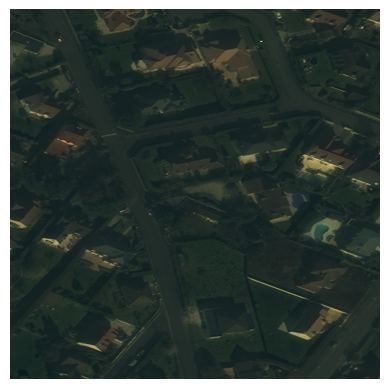

In [8]:
# Read the image using tifffile
img = tiff.imread(file_list[10]['image'])

# Check if the image is read correctly
print(f"Image shape: {img.shape}")
print(f"Image data type: {img.dtype}")

# Convert to float32
img_rgb = img.astype(np.float32)

# Print min and max values to check the range
print(f"Min value: {img_rgb.min()}, Max value: {img_rgb.max()}")

# Normalize the image for matplotlib display
img_rgb_normalized = img_rgb / img_rgb.max()

# Plot the image
plt.imshow(img_rgb_normalized)
plt.axis('off')  # Hide axis
plt.show()


# SETTING UP DATALOADER

In [9]:
class SpaceNet2(Dataset):
    def __init__(self, files, transforms_=None, preprocessing_fn=None):
        self.files = files
        self.transforms_ = transforms_
        self.preprocessing_fn = preprocessing_fn
        
    def pad_images_to_divisible_by_32(self, image, mask):
        # Calculate the padding sizes
        height, width = image.shape[-2], image.shape[-1]
        pad_height = (32 - height % 32) if height % 32 != 0 else 0
        pad_width = (32 - width % 32) if width % 32 != 0 else 0
        # Pad the image and mask
        image = F.pad(image, (0, pad_width, 0, pad_height), mode='constant', value=0)
        mask = F.pad(mask, (0, pad_width, 0, pad_height), mode='constant', value=0)
        return image, mask

    def rasterize_geojson(self, idx):
        gdf = gpd.read_file(self.files[idx]['mask'])
        with rio.open(self.files[idx]['image']) as raster:
            r = raster.read(1)
            gdf = gdf.to_crs(raster.crs)  # Ensure CRS match
            mask = np.zeros_like(r, dtype=np.uint8)
            for geom in gdf['geometry']:
                geom_px = features.geometry_mask([geom], transform=raster.transform, out_shape=r.shape, invert=True)
                mask[geom_px] = 1
        return mask

    def __getitem__(self, idx):
        img = tiff.imread(self.files[idx]['image'])
        img = img.astype(np.float32)
        mask = self.rasterize_geojson(idx)
        
        if self.transforms_:
            aug = self.transforms_(image=img, mask=mask)
            img, mask = aug['image'], aug['mask']
            
        #######Transpose Image##########################
        img = img.transpose(2,1,0)
        img = torch.tensor(img, dtype=torch.float32)
        mask = torch.tensor(mask, dtype=torch.uint8)
        
        # Normalize the image tiles to the range [0, 1]
        img_tiles_normalized = (img - img.min()) / (img.max() - img.min())
        
        # Pad image and mask to be divisible by 32
        img_tiles_normalized, mask = self.pad_images_to_divisible_by_32(img_tiles_normalized, mask)
        
        # return img, mask
        return img_tiles_normalized, mask

    def __len__(self):
        return len(self.files)

In [10]:
class SpaceNet2(Dataset):
    def __init__(self, files, transforms_=None, preprocessing_fn=None):
        self.files = files
        self.transforms_ = transforms_
        self.preprocessing_fn = preprocessing_fn

    def pad_images_to_divisible_by_32(self, image, mask):
        # Calculate the padding sizes
        height, width = image.shape[-2], image.shape[-1]
        pad_height = (32 - height % 32) if height % 32 != 0 else 0
        pad_width = (32 - width % 32) if width % 32 != 0 else 0
        # Pad the image and mask
        image = F.pad(image, (0, pad_width, 0, pad_height), mode='constant', value=0)
        mask = F.pad(mask, (0, pad_width, 0, pad_height), mode='constant', value=0)
        return image, mask

    def rasterize_geojson(self, idx):
        gdf = gpd.read_file(self.files[idx]['mask'])
        with rio.open(self.files[idx]['image']) as raster:
            r = raster.read(1)
            gdf = gdf.to_crs(raster.crs)  # Ensure CRS match
            mask = np.zeros_like(r, dtype=np.uint8)
            for geom in gdf['geometry']:
                geom_px = features.geometry_mask([geom], transform=raster.transform, out_shape=r.shape, invert=True)
                mask[geom_px] = 1
        return mask

    def __getitem__(self, idx):
        while True:
            img = tiff.imread(self.files[idx]['image'])
            img = img.astype(np.float32)
            mask = self.rasterize_geojson(idx)

            # Check if the mask is empty
            if not np.all(mask == 0):
                break
            
            # Pick a new index
            idx = np.random.randint(len(self.files))

        if self.transforms_:
            aug = self.transforms_(image=img, mask=mask)
            img, mask = aug['image'], aug['mask']
            
        # Transpose image
        img = img.transpose(2, 1, 0)
        img = torch.tensor(img, dtype=torch.float32)
        mask = torch.tensor(mask, dtype=torch.uint8)
        
        # Normalize the image tiles to the range [0, 1]
#         img_tiles_normalized = (img - img.min()) / (img.max() - img.min())
        # Normalize the image tiles to the range [0, 1]
        img_min, img_max = img.min(), img.max()
        if img_max != img_min:  # Avoid division by zero
            img_tiles_normalized = (img - img_min) / (img_max - img_min)
        else:
            img_tiles_normalized = img  # If min == max, normalization is unnecessary
        
        # Pad image and mask to be divisible by 32
        img_tiles_normalized, mask = self.pad_images_to_divisible_by_32(img_tiles_normalized, mask)
        
        return img_tiles_normalized, mask

    def __len__(self):
        return len(self.files)

In [11]:
preprocess_input = get_preprocessing_fn('resnet101', pretrained='imagenet')
batch_size = 16
train_transforms = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Blur(blur_limit=3, p=0.5)
#     A.Rotate(limit=40, p=0.9, border_mode=cv2.BORDER_CONSTANT)
    ],is_check_shapes = False)

device = torch.device("cuda" if torch.cuda.is_available else "cpu")
train_files, val_files = train_test_split(file_list, test_size=0.2, random_state=42, shuffle=True)

train_dataset = SpaceNet2(files=train_files, transforms_=train_transforms, preprocessing_fn=preprocess_input)
val_dataset = SpaceNet2(files=val_files, preprocessing_fn=preprocess_input)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

print(f'len train: {len(train_files)}')
print(f'len val: {len(val_files)}')

len train: 918
len val: 230


# VISUALIZE DATALOADER

In [12]:
def visualize_loaded_tiles(img_tiles, mask_tiles):
    num_tiles, _, _, _ = img_tiles.shape
    rows = int(math.sqrt(num_tiles))
    cols = int(math.sqrt(num_tiles))

    plt.figure(figsize=(15, 15))
    # Display individual tiles with masks
    for i, tile in enumerate(img_tiles):
        plt.subplot(rows, cols, i + 1)
        tile = tile.permute(2,1,0)
        plt.imshow(tile)
        plt.imshow(mask_tiles[i], cmap='seismic', alpha=0.35)
        plt.xticks([])
        plt.yticks([])
        plt.title(f'Tile {i + 1}\nTile Size: {tile.shape}')
    plt.tight_layout()
    plt.show()

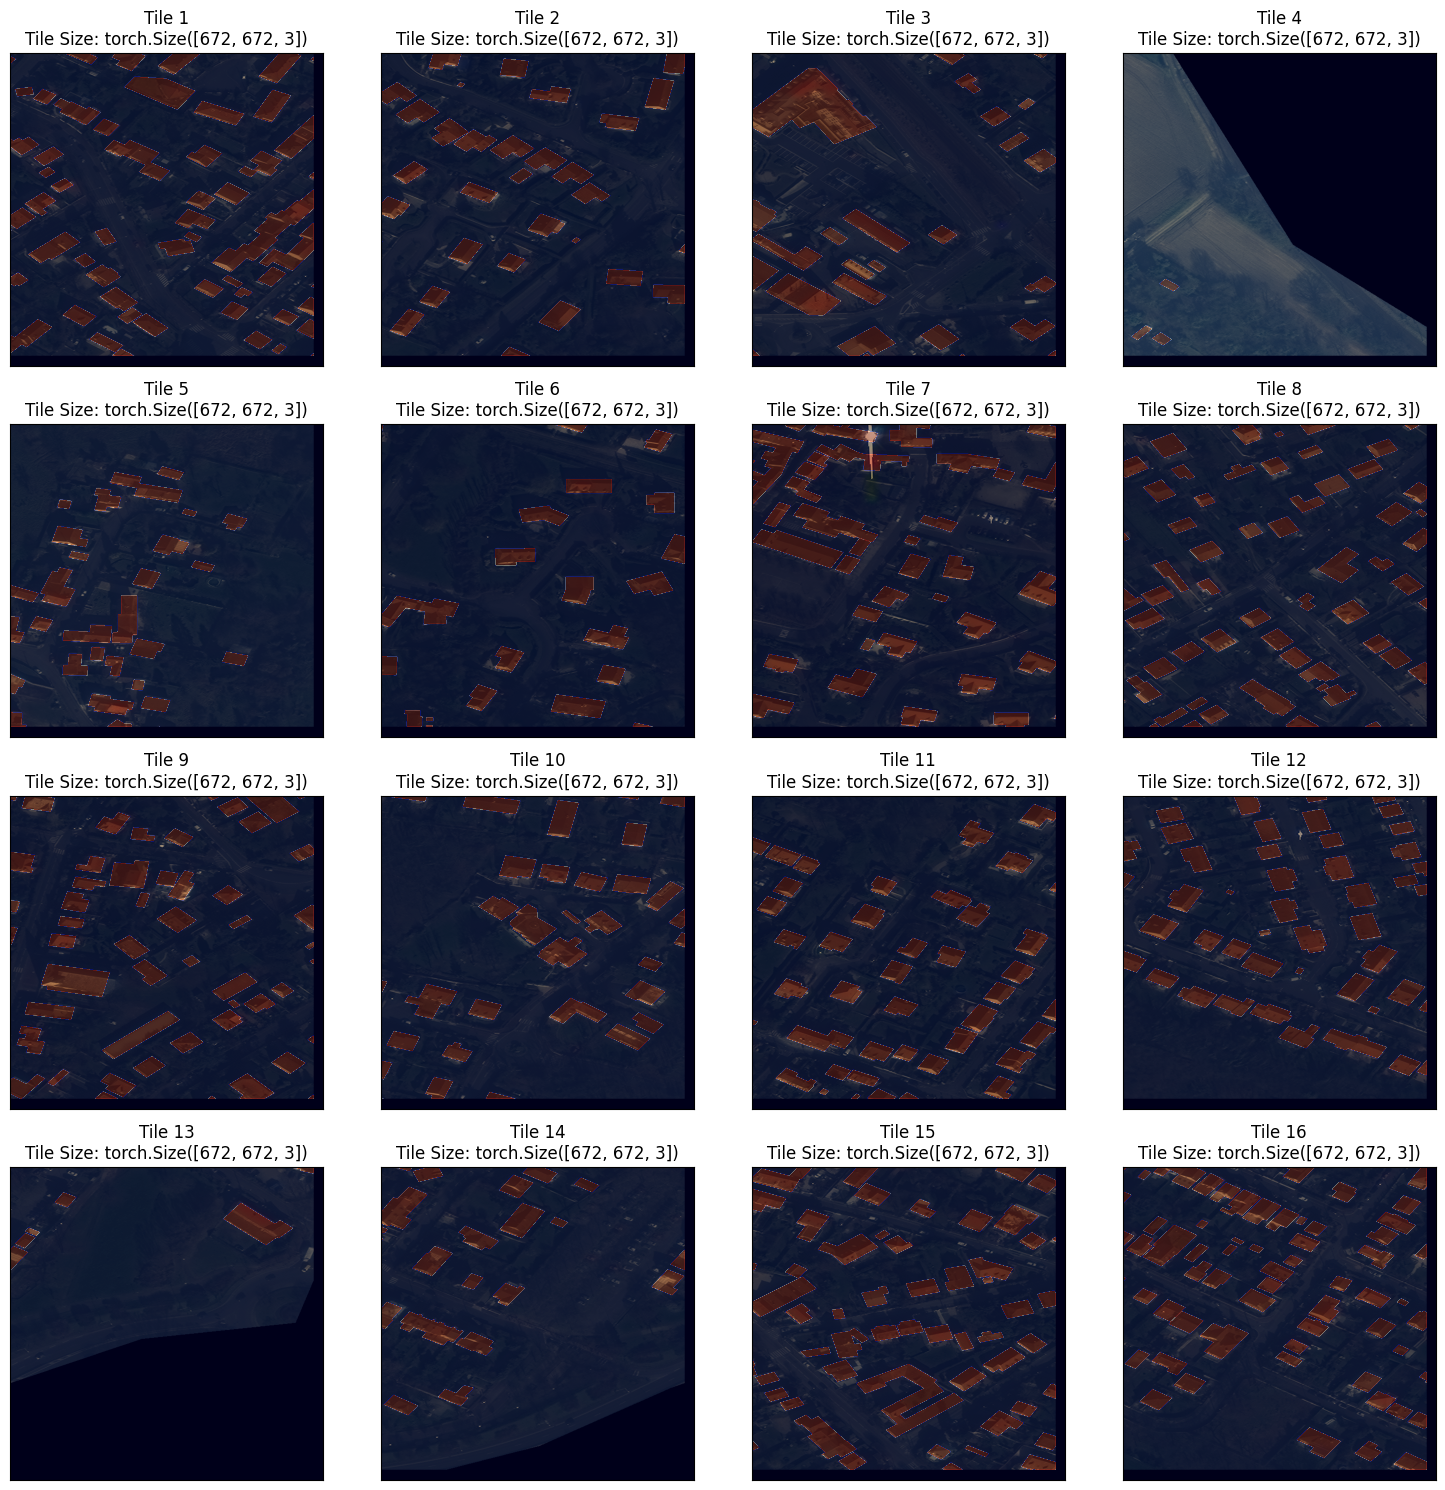

In [13]:
images, masks = next(iter(val_loader))
visualize_loaded_tiles(images, masks)

# MODEL BUILDING

In [14]:
class_size = 1
model = smp.Unet(
    encoder_name="resnet101",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=class_size,                      # model output channels (number of classes in your dataset)
)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)
print(device)

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth
100%|██████████| 170M/170M [00:10<00:00, 17.2MB/s]


cuda


In [15]:
preprocess_input = get_preprocessing_fn('resnet101', pretrained='imagenet')
batch_size = 8
train_transforms = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Blur(blur_limit=3, p=0.5),
    A.Rotate(limit=40, p=0.9, border_mode=cv2.BORDER_CONSTANT)
    ],is_check_shapes = False)

device = torch.device("cuda" if torch.cuda.is_available else "cpu")
train_files, val_files = train_test_split(file_list, test_size=0.2, random_state=42, shuffle=True)

train_dataset = SpaceNet2(files=train_files, transforms_=train_transforms, preprocessing_fn=preprocess_input)
val_dataset = SpaceNet2(files=val_files, preprocessing_fn=preprocess_input)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

print(f'len train: {len(train_files)}')
print(f'len val: {len(val_files)}')

len train: 918
len val: 230


In [16]:
def train(dataloader, model, loss_fn, optimizer, lr_scheduler):
    size = len(dataloader.dataset) # number of samples
    num_batches = len(dataloader) # batches per epoch
    model.train() # to training mode.
    epoch_loss = 0
    epoch_iou_score = 0
    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Train')
    for batch_i, batch in pbar:
#     for batch_i, batch in enumerate(dataloader):
        x, y = batch[0].to(device), batch[1].to(device) # move data to GPU
        optimizer.zero_grad()
        pred = model(x)
        loss = loss_fn(pred, y)

        loss.backward() # backpropagation to compute gradients
        optimizer.step() # update model params

        epoch_loss += loss.item() # tensor -> python value
        pred = pred.squeeze(dim=1)
        pred = torch.sigmoid(pred)
        y = y.round().long()
        tp, fp, fn, tn = smp.metrics.get_stats(pred, y, mode='binary', threshold=0.5)
        iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro").item()
        epoch_iou_score += iou_score
    lr_scheduler.step(iou_score)
    # return avg loss of epoch, acc of epoch
    return epoch_loss/num_batches, epoch_iou_score/num_batches

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset) # number of samples
    num_batches = len(dataloader) # batches per epoch
    model.eval() # model to test mode.
    epoch_loss = 0
    epoch_iou_score = 0
    # No gradient for test data
    with torch.no_grad():
        pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Train')
        for batch_i, batch in pbar:
#         for batch_i, batch in enumerate(dataloader):
            x, y = batch[0].to(device), batch[1].to(device) # move data to GPU
            # Compute prediction loss
            pred = model(x)
            loss = loss_fn(pred, y)
            # write to logs
            epoch_loss += loss.item()
            pred = pred.squeeze(dim=1)
            pred = torch.sigmoid(pred)
            y = y.round().long()
            tp, fp, fn, tn = smp.metrics.get_stats(pred, y, mode='binary', threshold=0.5)
            iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro").item()
            epoch_iou_score += iou_score
          
    return epoch_loss/num_batches, epoch_iou_score/num_batches

# MODEL TRAINING

In [17]:
EPOCHS = 100
logs = {
    'train_loss': [], 'val_loss': [],
    'train_iou_score': [], 'val_iou_score': [],
}

if os.path.exists('/kaggle/working/checkpoints') == False:
    os.mkdir("/kaggle/working/checkpoints")

loss_fn = smp.losses.DiceLoss(mode="binary")
learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size= 200, gamma=0.1)
step_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=100)

# Earlystopping
patience = 8
counter = 0
best_loss = np.inf

model.to(device)
for epoch in tqdm(range(EPOCHS)):
    train_loss, train_iou_score = train(train_loader, model, loss_fn, optimizer, step_lr_scheduler)
    val_loss, val_iou_score = test(val_loader, model, loss_fn)
    logs['train_loss'].append(train_loss)
    logs['val_loss'].append(val_loss)
    logs['train_iou_score'].append(train_iou_score)
    logs['val_iou_score'].append(val_iou_score)

    print(f'EPOCH: {str(epoch+1).zfill(3)} \
    train_loss: {train_loss:.4f}, val_loss: {val_loss:.4f} \
    train_iou_score: {train_iou_score:.3f}, val_iou_score: {val_iou_score:.3f} \
    lr: {optimizer.param_groups[0]["lr"]}')
    # On epoch end
    torch.save(model.state_dict(), "/kaggle/working/checkpoints/last.pth")
    # check improvement
    if val_loss < best_loss:
        counter = 0
        best_loss = val_loss
        torch.save(model.state_dict(), "/kaggle/working/checkpoints/best.pth")
    else:
        counter += 1
    if counter >= patience:
        print("Earlystop!")
        break

  0%|          | 0/100 [00:00<?, ?it/s]

Train:   0%|          | 0/115 [00:00<?, ?it/s]

Train:   0%|          | 0/29 [00:00<?, ?it/s]

EPOCH: 001     train_loss: 0.7684, val_loss: 0.7244     train_iou_score: 0.148, val_iou_score: 0.177     lr: 0.0001


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Train:   0%|          | 0/29 [00:00<?, ?it/s]

EPOCH: 002     train_loss: 0.7445, val_loss: 0.7139     train_iou_score: 0.159, val_iou_score: 0.177     lr: 0.0001


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Train:   0%|          | 0/29 [00:00<?, ?it/s]

EPOCH: 003     train_loss: 0.7264, val_loss: 0.6952     train_iou_score: 0.168, val_iou_score: 0.190     lr: 0.0001


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Train:   0%|          | 0/29 [00:00<?, ?it/s]

EPOCH: 004     train_loss: 0.7137, val_loss: 0.6999     train_iou_score: 0.176, val_iou_score: 0.185     lr: 0.0001


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Train:   0%|          | 0/29 [00:00<?, ?it/s]

EPOCH: 005     train_loss: 0.7100, val_loss: 0.6974     train_iou_score: 0.177, val_iou_score: 0.185     lr: 0.0001


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Train:   0%|          | 0/29 [00:00<?, ?it/s]

EPOCH: 006     train_loss: 0.6926, val_loss: 0.6918     train_iou_score: 0.187, val_iou_score: 0.187     lr: 0.0001


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Train:   0%|          | 0/29 [00:00<?, ?it/s]

EPOCH: 007     train_loss: 0.6774, val_loss: 0.6784     train_iou_score: 0.198, val_iou_score: 0.197     lr: 0.0001


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Train:   0%|          | 0/29 [00:00<?, ?it/s]

EPOCH: 008     train_loss: 0.6716, val_loss: 0.6819     train_iou_score: 0.202, val_iou_score: 0.194     lr: 0.0001


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Train:   0%|          | 0/29 [00:00<?, ?it/s]

EPOCH: 009     train_loss: 0.6627, val_loss: 0.6572     train_iou_score: 0.208, val_iou_score: 0.211     lr: 0.0001


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Train:   0%|          | 0/29 [00:00<?, ?it/s]

EPOCH: 010     train_loss: 0.6515, val_loss: 0.6786     train_iou_score: 0.217, val_iou_score: 0.196     lr: 0.0001


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Train:   0%|          | 0/29 [00:00<?, ?it/s]

EPOCH: 011     train_loss: 0.6454, val_loss: 0.6547     train_iou_score: 0.220, val_iou_score: 0.212     lr: 0.0001


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Train:   0%|          | 0/29 [00:00<?, ?it/s]

EPOCH: 012     train_loss: 0.6334, val_loss: 0.6323     train_iou_score: 0.229, val_iou_score: 0.230     lr: 0.0001


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Train:   0%|          | 0/29 [00:00<?, ?it/s]

EPOCH: 013     train_loss: 0.6137, val_loss: 0.6295     train_iou_score: 0.244, val_iou_score: 0.231     lr: 0.0001


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Train:   0%|          | 0/29 [00:00<?, ?it/s]

EPOCH: 014     train_loss: 0.5946, val_loss: 0.6079     train_iou_score: 0.258, val_iou_score: 0.247     lr: 0.0001


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Train:   0%|          | 0/29 [00:00<?, ?it/s]

EPOCH: 015     train_loss: 0.5757, val_loss: 0.5711     train_iou_score: 0.274, val_iou_score: 0.277     lr: 0.0001


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Train:   0%|          | 0/29 [00:00<?, ?it/s]

EPOCH: 016     train_loss: 0.5387, val_loss: 0.5498     train_iou_score: 0.306, val_iou_score: 0.297     lr: 0.0001


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Train:   0%|          | 0/29 [00:00<?, ?it/s]

EPOCH: 017     train_loss: 0.5063, val_loss: 0.5340     train_iou_score: 0.333, val_iou_score: 0.308     lr: 0.0001


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Train:   0%|          | 0/29 [00:00<?, ?it/s]

EPOCH: 018     train_loss: 0.4781, val_loss: 0.4788     train_iou_score: 0.358, val_iou_score: 0.356     lr: 0.0001


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Train:   0%|          | 0/29 [00:00<?, ?it/s]

EPOCH: 019     train_loss: 0.4484, val_loss: 0.4771     train_iou_score: 0.386, val_iou_score: 0.359     lr: 0.0001


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Train:   0%|          | 0/29 [00:00<?, ?it/s]

EPOCH: 020     train_loss: 0.4229, val_loss: 0.4370     train_iou_score: 0.410, val_iou_score: 0.396     lr: 0.0001


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Train:   0%|          | 0/29 [00:00<?, ?it/s]

EPOCH: 021     train_loss: 0.4016, val_loss: 0.4384     train_iou_score: 0.430, val_iou_score: 0.394     lr: 0.0001


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Train:   0%|          | 0/29 [00:00<?, ?it/s]

EPOCH: 022     train_loss: 0.3875, val_loss: 0.3958     train_iou_score: 0.445, val_iou_score: 0.436     lr: 0.0001


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Train:   0%|          | 0/29 [00:00<?, ?it/s]

EPOCH: 023     train_loss: 0.3741, val_loss: 0.4009     train_iou_score: 0.459, val_iou_score: 0.431     lr: 0.0001


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Train:   0%|          | 0/29 [00:00<?, ?it/s]

EPOCH: 024     train_loss: 0.3587, val_loss: 0.3680     train_iou_score: 0.475, val_iou_score: 0.465     lr: 0.0001


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Train:   0%|          | 0/29 [00:00<?, ?it/s]

EPOCH: 025     train_loss: 0.3442, val_loss: 0.3765     train_iou_score: 0.491, val_iou_score: 0.457     lr: 0.0001


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Train:   0%|          | 0/29 [00:00<?, ?it/s]

EPOCH: 026     train_loss: 0.3372, val_loss: 0.3570     train_iou_score: 0.498, val_iou_score: 0.476     lr: 0.0001


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Train:   0%|          | 0/29 [00:00<?, ?it/s]

EPOCH: 027     train_loss: 0.3334, val_loss: 0.3568     train_iou_score: 0.502, val_iou_score: 0.476     lr: 0.0001


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Train:   0%|          | 0/29 [00:00<?, ?it/s]

EPOCH: 028     train_loss: 0.3289, val_loss: 0.3557     train_iou_score: 0.507, val_iou_score: 0.478     lr: 0.0001


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Train:   0%|          | 0/29 [00:00<?, ?it/s]

EPOCH: 029     train_loss: 0.3170, val_loss: 0.3351     train_iou_score: 0.520, val_iou_score: 0.500     lr: 0.0001


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Train:   0%|          | 0/29 [00:00<?, ?it/s]

EPOCH: 030     train_loss: 0.3131, val_loss: 0.3308     train_iou_score: 0.525, val_iou_score: 0.505     lr: 0.0001


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Train:   0%|          | 0/29 [00:00<?, ?it/s]

EPOCH: 031     train_loss: 0.3040, val_loss: 0.3175     train_iou_score: 0.535, val_iou_score: 0.520     lr: 0.0001


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Train:   0%|          | 0/29 [00:00<?, ?it/s]

EPOCH: 032     train_loss: 0.2980, val_loss: 0.3222     train_iou_score: 0.543, val_iou_score: 0.514     lr: 0.0001


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Train:   0%|          | 0/29 [00:00<?, ?it/s]

EPOCH: 033     train_loss: 0.2933, val_loss: 0.3132     train_iou_score: 0.548, val_iou_score: 0.525     lr: 0.0001


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Train:   0%|          | 0/29 [00:00<?, ?it/s]

EPOCH: 034     train_loss: 0.2902, val_loss: 0.3310     train_iou_score: 0.552, val_iou_score: 0.505     lr: 0.0001


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Train:   0%|          | 0/29 [00:00<?, ?it/s]

EPOCH: 035     train_loss: 0.2928, val_loss: 0.3348     train_iou_score: 0.548, val_iou_score: 0.500     lr: 0.0001


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Train:   0%|          | 0/29 [00:00<?, ?it/s]

EPOCH: 036     train_loss: 0.2772, val_loss: 0.2866     train_iou_score: 0.568, val_iou_score: 0.556     lr: 0.0001


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Train:   0%|          | 0/29 [00:00<?, ?it/s]

EPOCH: 037     train_loss: 0.2720, val_loss: 0.2931     train_iou_score: 0.574, val_iou_score: 0.548     lr: 0.0001


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Train:   0%|          | 0/29 [00:00<?, ?it/s]

EPOCH: 038     train_loss: 0.2713, val_loss: 0.2931     train_iou_score: 0.575, val_iou_score: 0.548     lr: 0.0001


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Train:   0%|          | 0/29 [00:00<?, ?it/s]

EPOCH: 039     train_loss: 0.2683, val_loss: 0.2845     train_iou_score: 0.578, val_iou_score: 0.559     lr: 0.0001


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Train:   0%|          | 0/29 [00:00<?, ?it/s]

EPOCH: 040     train_loss: 0.2596, val_loss: 0.2746     train_iou_score: 0.589, val_iou_score: 0.570     lr: 0.0001


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Train:   0%|          | 0/29 [00:00<?, ?it/s]

EPOCH: 041     train_loss: 0.2584, val_loss: 0.2862     train_iou_score: 0.591, val_iou_score: 0.556     lr: 0.0001


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Train:   0%|          | 0/29 [00:00<?, ?it/s]

EPOCH: 042     train_loss: 0.2530, val_loss: 0.2893     train_iou_score: 0.597, val_iou_score: 0.553     lr: 0.0001


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Train:   0%|          | 0/29 [00:00<?, ?it/s]

EPOCH: 043     train_loss: 0.2486, val_loss: 0.2815     train_iou_score: 0.603, val_iou_score: 0.562     lr: 0.0001


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Train:   0%|          | 0/29 [00:00<?, ?it/s]

EPOCH: 044     train_loss: 0.2496, val_loss: 0.2708     train_iou_score: 0.602, val_iou_score: 0.575     lr: 0.0001


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Train:   0%|          | 0/29 [00:00<?, ?it/s]

EPOCH: 045     train_loss: 0.2490, val_loss: 0.2671     train_iou_score: 0.602, val_iou_score: 0.580     lr: 0.0001


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Train:   0%|          | 0/29 [00:00<?, ?it/s]

EPOCH: 046     train_loss: 0.2450, val_loss: 0.2713     train_iou_score: 0.608, val_iou_score: 0.574     lr: 0.0001


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Train:   0%|          | 0/29 [00:00<?, ?it/s]

EPOCH: 047     train_loss: 0.2390, val_loss: 0.2652     train_iou_score: 0.615, val_iou_score: 0.582     lr: 0.0001


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Train:   0%|          | 0/29 [00:00<?, ?it/s]

EPOCH: 048     train_loss: 0.2400, val_loss: 0.2573     train_iou_score: 0.614, val_iou_score: 0.592     lr: 0.0001


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Train:   0%|          | 0/29 [00:00<?, ?it/s]

EPOCH: 049     train_loss: 0.2401, val_loss: 0.2619     train_iou_score: 0.614, val_iou_score: 0.586     lr: 0.0001


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Train:   0%|          | 0/29 [00:00<?, ?it/s]

EPOCH: 050     train_loss: 0.2366, val_loss: 0.2650     train_iou_score: 0.618, val_iou_score: 0.582     lr: 0.0001


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Train:   0%|          | 0/29 [00:00<?, ?it/s]

EPOCH: 051     train_loss: 0.2375, val_loss: 0.2562     train_iou_score: 0.617, val_iou_score: 0.593     lr: 0.0001


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Train:   0%|          | 0/29 [00:00<?, ?it/s]

EPOCH: 052     train_loss: 0.2323, val_loss: 0.2565     train_iou_score: 0.624, val_iou_score: 0.593     lr: 0.0001


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Train:   0%|          | 0/29 [00:00<?, ?it/s]

EPOCH: 053     train_loss: 0.2292, val_loss: 0.2529     train_iou_score: 0.628, val_iou_score: 0.597     lr: 0.0001


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Train:   0%|          | 0/29 [00:00<?, ?it/s]

EPOCH: 054     train_loss: 0.2327, val_loss: 0.2568     train_iou_score: 0.623, val_iou_score: 0.592     lr: 0.0001


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Train:   0%|          | 0/29 [00:00<?, ?it/s]

EPOCH: 055     train_loss: 0.2304, val_loss: 0.2546     train_iou_score: 0.626, val_iou_score: 0.596     lr: 0.0001


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Train:   0%|          | 0/29 [00:00<?, ?it/s]

EPOCH: 056     train_loss: 0.2275, val_loss: 0.2567     train_iou_score: 0.630, val_iou_score: 0.593     lr: 0.0001


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Train:   0%|          | 0/29 [00:00<?, ?it/s]

EPOCH: 057     train_loss: 0.2260, val_loss: 0.2541     train_iou_score: 0.632, val_iou_score: 0.596     lr: 0.0001


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Train:   0%|          | 0/29 [00:00<?, ?it/s]

EPOCH: 058     train_loss: 0.2246, val_loss: 0.2563     train_iou_score: 0.634, val_iou_score: 0.593     lr: 0.0001


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Train:   0%|          | 0/29 [00:00<?, ?it/s]

EPOCH: 059     train_loss: 0.2203, val_loss: 0.2470     train_iou_score: 0.640, val_iou_score: 0.605     lr: 0.0001


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Train:   0%|          | 0/29 [00:00<?, ?it/s]

EPOCH: 060     train_loss: 0.2224, val_loss: 0.2527     train_iou_score: 0.637, val_iou_score: 0.598     lr: 0.0001


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Train:   0%|          | 0/29 [00:00<?, ?it/s]

EPOCH: 061     train_loss: 0.2228, val_loss: 0.2579     train_iou_score: 0.636, val_iou_score: 0.591     lr: 0.0001


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Train:   0%|          | 0/29 [00:00<?, ?it/s]

EPOCH: 062     train_loss: 0.2208, val_loss: 0.2498     train_iou_score: 0.639, val_iou_score: 0.601     lr: 0.0001


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Train:   0%|          | 0/29 [00:00<?, ?it/s]

EPOCH: 063     train_loss: 0.2195, val_loss: 0.2507     train_iou_score: 0.641, val_iou_score: 0.600     lr: 0.0001


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Train:   0%|          | 0/29 [00:00<?, ?it/s]

EPOCH: 064     train_loss: 0.2171, val_loss: 0.2450     train_iou_score: 0.644, val_iou_score: 0.608     lr: 0.0001


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Train:   0%|          | 0/29 [00:00<?, ?it/s]

EPOCH: 065     train_loss: 0.2175, val_loss: 0.2515     train_iou_score: 0.644, val_iou_score: 0.600     lr: 0.0001


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Train:   0%|          | 0/29 [00:00<?, ?it/s]

EPOCH: 066     train_loss: 0.2165, val_loss: 0.2448     train_iou_score: 0.645, val_iou_score: 0.608     lr: 0.0001


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Train:   0%|          | 0/29 [00:00<?, ?it/s]

EPOCH: 067     train_loss: 0.2161, val_loss: 0.2450     train_iou_score: 0.645, val_iou_score: 0.607     lr: 0.0001


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Train:   0%|          | 0/29 [00:00<?, ?it/s]

EPOCH: 068     train_loss: 0.2152, val_loss: 0.2511     train_iou_score: 0.647, val_iou_score: 0.600     lr: 0.0001


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Train:   0%|          | 0/29 [00:00<?, ?it/s]

EPOCH: 069     train_loss: 0.2123, val_loss: 0.2446     train_iou_score: 0.651, val_iou_score: 0.608     lr: 0.0001


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Train:   0%|          | 0/29 [00:00<?, ?it/s]

EPOCH: 070     train_loss: 0.2122, val_loss: 0.2351     train_iou_score: 0.651, val_iou_score: 0.620     lr: 0.0001


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Train:   0%|          | 0/29 [00:00<?, ?it/s]

EPOCH: 071     train_loss: 0.2143, val_loss: 0.2409     train_iou_score: 0.648, val_iou_score: 0.613     lr: 0.0001


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Train:   0%|          | 0/29 [00:00<?, ?it/s]

EPOCH: 072     train_loss: 0.2132, val_loss: 0.2375     train_iou_score: 0.649, val_iou_score: 0.617     lr: 0.0001


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Train:   0%|          | 0/29 [00:00<?, ?it/s]

EPOCH: 073     train_loss: 0.2130, val_loss: 0.2427     train_iou_score: 0.650, val_iou_score: 0.611     lr: 0.0001


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Train:   0%|          | 0/29 [00:00<?, ?it/s]

EPOCH: 074     train_loss: 0.2098, val_loss: 0.2345     train_iou_score: 0.654, val_iou_score: 0.621     lr: 0.0001


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Train:   0%|          | 0/29 [00:00<?, ?it/s]

EPOCH: 075     train_loss: 0.2127, val_loss: 0.2412     train_iou_score: 0.650, val_iou_score: 0.613     lr: 0.0001


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Train:   0%|          | 0/29 [00:00<?, ?it/s]

EPOCH: 076     train_loss: 0.2101, val_loss: 0.2326     train_iou_score: 0.654, val_iou_score: 0.624     lr: 0.0001


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Train:   0%|          | 0/29 [00:00<?, ?it/s]

EPOCH: 077     train_loss: 0.2053, val_loss: 0.2351     train_iou_score: 0.660, val_iou_score: 0.620     lr: 0.0001


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Train:   0%|          | 0/29 [00:00<?, ?it/s]

EPOCH: 078     train_loss: 0.2049, val_loss: 0.2359     train_iou_score: 0.661, val_iou_score: 0.619     lr: 0.0001


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Train:   0%|          | 0/29 [00:00<?, ?it/s]

EPOCH: 079     train_loss: 0.2015, val_loss: 0.2342     train_iou_score: 0.665, val_iou_score: 0.622     lr: 0.0001


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Train:   0%|          | 0/29 [00:00<?, ?it/s]

EPOCH: 080     train_loss: 0.2023, val_loss: 0.2388     train_iou_score: 0.664, val_iou_score: 0.616     lr: 0.0001


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Train:   0%|          | 0/29 [00:00<?, ?it/s]

EPOCH: 081     train_loss: 0.2010, val_loss: 0.2530     train_iou_score: 0.666, val_iou_score: 0.597     lr: 0.0001


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Train:   0%|          | 0/29 [00:00<?, ?it/s]

EPOCH: 082     train_loss: 0.2042, val_loss: 0.2346     train_iou_score: 0.662, val_iou_score: 0.621     lr: 0.0001


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Train:   0%|          | 0/29 [00:00<?, ?it/s]

EPOCH: 083     train_loss: 0.2011, val_loss: 0.2373     train_iou_score: 0.666, val_iou_score: 0.617     lr: 0.0001


Train:   0%|          | 0/115 [00:00<?, ?it/s]

Train:   0%|          | 0/29 [00:00<?, ?it/s]

EPOCH: 084     train_loss: 0.1988, val_loss: 0.2347     train_iou_score: 0.669, val_iou_score: 0.621     lr: 0.0001
Earlystop!


# MODEL EVALUATION

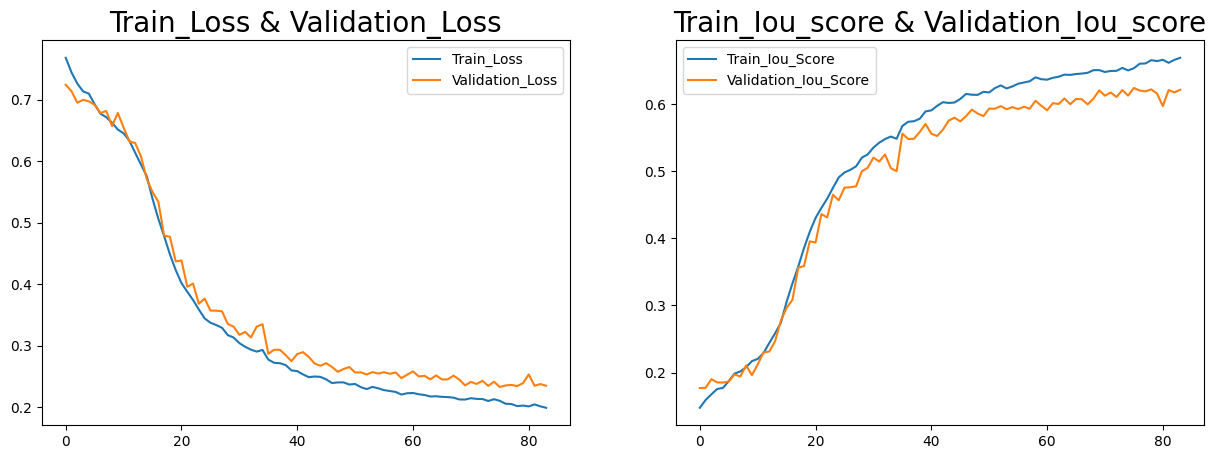

In [18]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(logs['train_loss'],label='Train_Loss')
plt.plot(logs['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(logs['train_iou_score'],label='Train_Iou_Score')
plt.plot(logs['val_iou_score'],label='Validation_Iou_Score')
plt.title('Train_Iou_score & Validation_Iou_score',fontsize=20)
plt.legend()